In [1]:
%pip install matplotlib JSAnimation
# %matplotlib inline

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from typing import List

# CartPole 环境准备

CartPole 是一个经典马尔可夫决策过程：下一时刻的状态 $s_{t+1}$ 仅和当前状态 $s_t$ 和动作 $a_t$ 有关。

In [3]:
import gymnasium as gym

env = gym.make('CartPole-v1', render_mode='rgb_array')

In [4]:
print(env.action_space)
print(env.observation_space)

Discrete(2)
Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)


## 简单演示

In [5]:
from JSAnimation.IPython_display import display_animation
from IPython.display import display, HTML

def collect_one_episode() -> List:
    env.reset()
    frames = []

    while True:
        frames.append(env.render())
        action = env.action_space.sample()
        # print(len(env.step(action)))
        state, reward, terminated, truncated, info = env.step(action)
        if terminated:
            break
    
    return frames

def demonstration_gif(frames: List, output_path: str) -> None:
    fig = plt.figure(figsize=(frames[0].shape[1]/72.0, frames[0].shape[0]/72.0), dpi=72)
    patch =plt.imshow(frames[0])
    plt.axis('off')

    def animate(i):
        img = patch.set_data(frames[i])
        return img
    
    anim = animation.FuncAnimation(plt.gcf(), animate, frames=len(frames), interval=50)
    anim.save(output_path)

    return HTML(anim.to_jshtml())

MovieWriter ffmpeg unavailable; using Pillow instead.


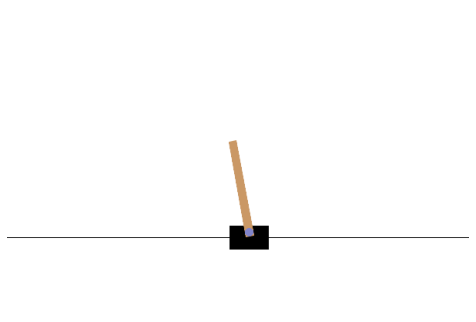

In [6]:
frames = collect_one_episode()
demonstration_gif(frames, '../output/rand_cartpole.gif')

## State Space 离散化

In [7]:
NUM_DIGITIZED = 6

def bins(clip_min, clip_max, num_bins=NUM_DIGITIZED):
    return np.linspace(clip_min, clip_max, num_bins+1)[1: -1]

def digitize_state(observation):
    pos, cart_v, angle, pole_v = observation
    digitized = [
        np.digitize(pos, bins=bins(-2.4, 2.4, NUM_DIGITIZED)),
        np.digitize(cart_v, bins=bins(-3., 3, NUM_DIGITIZED)),
        np.digitize(angle, bins=bins(-0.418, 0.418, NUM_DIGITIZED)),
        np.digitize(pole_v, bins=bins(-2, 2, NUM_DIGITIZED))
    ]
    ind = sum([d * (NUM_DIGITIZED ** i) for i, d in enumerate(digitized)])
    
    return ind

In [8]:
# 测试离散化，observation 转换为一个 0 - 6^4-1 之间的一个值 
obs = env.reset()
print(obs)
print(digitize_state(obs[0]))

(array([-0.03874307, -0.00113449, -0.01632437, -0.018614  ], dtype=float32), {})
518


# Q-Learning

In [9]:
class Agent:
    def __init__(self, action_sapce, n_states, eta=0.5, gamma=0.99, NUM_DIGITIZED=6) -> None:
        self.eta = eta
        self.gamma = gamma
        self.action_spaec = action_sapce
        self.NUM_DIGITIZED = NUM_DIGITIZED
        self.q_table = np.random.uniform(0, 1, size=(NUM_DIGITIZED ** n_states, action_sapce.n))

    # 从 OOP 的角度来讲这部分代码搬过来更好
    @staticmethod
    def _bins(clip_min, clip_max, num_bins=NUM_DIGITIZED):
        return np.linspace(clip_min, clip_max, num_bins+1)[1: -1]
    
    @staticmethod
    def _digitize_state(observation, num_digitized=NUM_DIGITIZED):
        pos, cart_v, angle, pole_v = observation
        digitized = [
            np.digitize(pos, bins=Agent._bins(-2.4, 2.4, num_digitized)),
            np.digitize(cart_v, bins=Agent._bins(-3., 3, num_digitized)),
            np.digitize(angle, bins=Agent._bins(-0.418, 0.418, num_digitized)),
            np.digitize(pole_v, bins=Agent._bins(-2, 2, num_digitized))
        ]
        ind = sum([d * (num_digitized ** i) for i, d in enumerate(digitized)])
        
        return ind
    
    def choose_action(self, state, episode):
        # 令其随着 episode 增加，探索性减少。
        # 示例中分母是 episode + 1，这里想收敛结果更明显一点，用了平方，还真 work。
        epsilon = 0.5/(episode ** 2 + 1)

        if np.random.random() < epsilon:
            action = self.action_spaec.sample()
        else:
            action = np.argmax(self.q_table[self._digitize_state(state)])
        
        return action


    def q_learning(self, obs, action, reward, obs_next):
        obs_ind = self._digitize_state(obs, self.NUM_DIGITIZED)
        obs_next_ind = self._digitize_state(obs_next, self.NUM_DIGITIZED)

        # 迭代
        self.q_table[obs_ind, action] = self.q_table[obs_ind, action] + self.eta * (reward + self.q_table[obs_next_ind].max() - self.q_table[obs_ind, action])


In [10]:
env = gym.make('CartPole-v1')
env.reset()

action_space = env.action_space
n_states = env.observation_space.shape[0]

agent = Agent(action_space, n_states)

TRAIN_EPISODES = 1000
MAX_STEPS_PER_EPISODES = 1000

for i in range(TRAIN_EPISODES):
    obs, _ = env.reset()
    terminated = False
    for step in range(MAX_STEPS_PER_EPISODES):
        action = agent.choose_action(obs, i)
        # state, reward, terminated, truncated, info
        obs_next, _, terminated, _, _ = env.step(action)
                
        if terminated:
            reward = -1
            # if step < 450:
            #     reward = -1
            # else:
            #     reward = 1
        elif step == MAX_STEPS_PER_EPISODES - 1:
            reward = 1
        else:
            reward = 0
        
        
        agent.q_learning(obs, action, reward, obs_next)
        obs = obs_next
        
        if terminated:
            if (i+1) % 10 == 0:
                print(f'episode {i+1} finished, step in this episode is {step}')
            break
    if not terminated and (i+1) % 10 == 0:
        print(f'episode {i+1} finished, step in this episode is {MAX_STEPS_PER_EPISODES}')

episode 10 finished, step in this episode is 8
episode 20 finished, step in this episode is 29
episode 30 finished, step in this episode is 50
episode 40 finished, step in this episode is 62
episode 50 finished, step in this episode is 151
episode 60 finished, step in this episode is 101
episode 70 finished, step in this episode is 42
episode 80 finished, step in this episode is 111
episode 90 finished, step in this episode is 181
episode 100 finished, step in this episode is 172
episode 110 finished, step in this episode is 176
episode 120 finished, step in this episode is 200
episode 130 finished, step in this episode is 220
episode 140 finished, step in this episode is 243
episode 150 finished, step in this episode is 184
episode 160 finished, step in this episode is 256
episode 170 finished, step in this episode is 168
episode 180 finished, step in this episode is 220
episode 190 finished, step in this episode is 1000
episode 200 finished, step in this episode is 1000
episode 210 f